# Design Thinking Project III

### Data setup
To allow the notebook to access files
1. Navigate to 'Shared with me' at https://drive.google.com/drive/shared-with-me
2. Right click '2DTerm3', 'Add Shortcut to Drive', 'My Drive'

### Python imports and google drive setup

In [1]:
# normal python imports
from typing import List

# python library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# custom library imports

# library configuration
pd.set_option('display.max_rows', 10000)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google'

## Utility functions

### Data getting utilities

In [3]:
def get_columns_by_search(df: pd.DataFrame, 
                          col_names: List[str], 
                          merge_names: List[str], 
                          search_str: str, 
                          exclude_str: str = "") -> pd.DataFrame:
  """
  Extract columns if search_str is in column name exclude_str is not.
  """
  cols = [col for col in col_names if search_str in col and exclude_str not in col]
  cols = merge_names + cols
  print(f'get_columns_by_search: {search_str}: {cols}')
  return df.loc[:, cols]

### Data generation utilities

In [4]:
def generate_alternate_features(features: pd.DataFrame,
                                ignore_cols: List[str]):
    more_features = features.copy()
    feature_names = [i for i in more_features.columns if i not in ignore_cols]

    for feature_name in feature_names:    
        for deg in range(2, 4):
            new_name = f"{feature_name}^{deg}"
            more_features[new_name] = more_features[feature_name] ** deg
    
    feature_renames = {k: f"{k}^1" for k in feature_names}
    more_features = more_features.rename(columns=feature_renames)
    more_features = more_features.reindex(sorted(more_features.columns), axis=1)
    return more_features

### Data cleaning utilities

In [5]:
def remove_nan(df: pd.DataFrame,
               ffill_cols: List[str] = [],
               ffill_group: str = None):
    """
    Fill forward specified columns, drop all rows with NaN after
    """
    logShapeBefore = df.shape
    if len(ffill_cols) > 0:
        if ffill_group:
            df[ffill_cols] = df.groupby(ffill_group)[ffill_cols].ffill()
        else:            
            df.loc[:, ffill_cols] = df.loc[:, ffill_cols].ffill()
    df = df.dropna()
    print('remove_nan: shape before', logShapeBefore, 'after', df.shape)
    return df

def merge_df(src_df: pd.DataFrame,
             tar_df: pd.DataFrame):
    """
    Merge two dataframes by common column names
    """
    merge_cols = [i for i in src_df.columns if i in tar_df.columns]
    print('merge_df: merging by', merge_cols)
    merged = pd.merge(src_df, tar_df, left_on=merge_cols, right_on=merge_cols)
    return merged.dropna()

def align_df(src_df: pd.DataFrame,
             tar_df: pd.DataFrame):
    """
    Get intersection between dataframes, and split them back
    """
    src_cols = src_df.columns
    tar_cols = tar_df.columns
    merged = merge_df(src_df, tar_df)
    src = merged.loc[:, src_cols]
    tar = merged.loc[:, tar_cols]
    return src, tar

def clean(df_feature: pd.DataFrame,
          df_target: pd.DataFrame,
          ffill_cols: List[str] = [],
          ffill_group: str = None):
    """
    1) NaN handling: fill forward or drop (default)
    2) Align feature and target data frames: inner join on common columns and split
    """
    feature_ffill = [i for i in ffill_cols if i in df_feature.columns]
    target_ffill = [i for i in ffill_cols if i in df_target.columns]
    feature = remove_nan(df_feature, 
                         ffill_cols=feature_ffill, 
                         ffill_group=ffill_group)
    target = remove_nan(df_target, 
                        ffill_cols=target_ffill, 
                        ffill_group=ffill_group)
    logFeatureShape, logTargetShape = feature.shape, target.shape
    feature, target = align_df(feature, target)
    print('Align feature and targets: before shape', logFeatureShape, logTargetShape, 
          'after shape', feature.shape, target.shape)
    display(feature.describe())
    display(target.describe())
    return feature, target

### Data preparation utilities

In [6]:
def prepare_feature(df_feature):
    """
    Add a ones column (beta_0) for regression models
    """
    feature = df_feature.to_numpy()
    ones = np.ones((feature.shape[0], 1))
    feature = np.concatenate((ones, feature), axis=1)
    return feature

def prepare_target(df_target):
    """
    Transform target dataframe to numpy array
    """
    return df_target.to_numpy()

def split_data(df_feature, 
               df_target, 
               random_state=None, 
               test_size=0.5):
    """
    Split data according to given seed and test size (0-1)
    """
    n = df_feature.shape[0]
    np.random.seed(random_state)
    select = np.random.choice(n, int(n * test_size), replace=False)
    df_feature_train = df_feature.loc[~df_feature.index.isin(select), :]
    df_feature_test = df_feature.loc[select, :]
    df_target_train = df_target.loc[~df_feature.index.isin(select), :]
    df_target_test = df_target.loc[select, :]
    
    # print(df_feature_train.shape, df_feature_test.shape, df_target_train.shape, df_target_test.shape)
    return df_feature_train, df_feature_test, df_target_train, df_target_test

def normalise_z(df: pd.DataFrame,
                ignore_cols: List[str] = [],
                group_name: str = None):
    """
    Standardise all columns except for those in ignore_cols
    Apply group by if specified
    """
    normalise_fn = lambda x: (x - x.mean()) / x.std()
    
    colnames = df.columns
    affected_cols = [col for col in colnames if col not in ignore_cols]

    if group_name:
        normalise = df.groupby(group_name)[affected_cols]
    else:
        normalise = df.loc[:, affected_cols]
    
    normalise = normalise.apply(normalise_fn)
    df.loc[:, affected_cols] = normalise
    return df

### Regression utilities

In [7]:
def predict(df_feature, beta):
    feature = prepare_feature(normalise_z(df_feature))
    pred = predict_norm(feature, beta)
    return pred

def predict_norm(X, beta):
    return np.matmul(X, beta)

def compute_mse_cost(X, y, beta):
    J = 0
    numdata = X.shape[0]
    J = (np.matmul(X, beta) - y)**2
    J = J.sum() / 2 / numdata
    return J

def gradient_descent(X, y, beta, alpha, num_iters):
    numdata = X.shape[0]
    for _ in range(num_iters):
        J_storage = compute_mse_cost(X, y, beta)
        beta = beta - alpha * np.matmul(X.T, (np.matmul(X, beta) - y)) / numdata
    return beta, J_storage

def runRegression(df_features: pd.DataFrame,
                  df_target: pd.DataFrame,
                  ignore_cols: List[str] = [],
                  is_normalised: bool = False,
                  seed: int = 100,
                  split_ratio: float = 0.3,
                  iterations: int = 1500,
                  alpha: float = 0.01):
    
    # Split the data set into training and test
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(
        df_features, df_target, 100, 0.3)

    # Normalise the features using z normalization
    df_features_train_z = df_features_train
    if not is_normalised:
        df_features_train_z = normalise_z(df_features_train)

    # Change the features and the target to numpy array using the prepare functions
    X = prepare_feature(df_features_train_z)
    target = prepare_target(df_target_train)
    beta = np.zeros((X.shape[1], 1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, num_iters=iterations)

    return df_features_test, df_target_test, beta, J_storage

### Evaluation utilities

In [8]:
def r2_score(y, ypred):
    ssres = ((y-ypred)**2).sum()
    sstot = ((y-y.mean())**2).sum()
    return 1- ssres/sstot

def mean_squared_error(target, pred):
    n = target.shape[0]
    return ((target - pred)**2).sum() / n

def adjusted_r2(target, pred, n_features, n_points):
    r2 = r2_score(target, pred)
    return 1 - (1 - r2) * (n_points - 1) / (n_points - n_features - 1)

### Visualisation utilities

In [9]:
def plot_group_feature(df: pd.DataFrame,
                       x_name: str,
                       y_name: str,
                       group_name: str,
                       scatter: bool = True):
    """
    Plot feature y by x, grouped by specified column
    """
    fig, ax = plt.subplots(figsize=(10,4))
    for key, grp in df.groupby(group_name):
        if scatter:
            ax.scatter(grp[x_name], grp[y_name], label=key)
        else:
            ax.plot(grp[x_name], grp[y_name], label=key)
    ax.legend()
    return fig, ax

def plot_group_feature_split(df: pd.DataFrame,
                             x_name: str,
                             y_name: str,
                             group_name: str,
                             plot_type,
                             height: float = 2.5):
    """
    Plot feature y by x, split based on specified column
    """
    grid = sns.FacetGrid(df, col=group_name, col_wrap=3, despine=True, height=height)
    grid.map(plot_type, x_name, y_name, scatter_kws={'alpha': 0.05})
    grid.set_xlabels("")
    grid.set_ylabels("")
    fig = grid.figure

    # add common labels
    fig.add_subplot(111, frameon=False)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)
    plt.tick_params(labelcolor='none', which='both', 
                    top=False, bottom=False, left=False, right=False)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

    return grid

## OWID Dataset

### Load data and obtain features by keywords

In [11]:
# RAW_DATA_FILE = '/content/drive/My Drive/2DTerm3/Raw Data/owid-covid-data.csv'
RAW_DATA_FILE = 'owid-covid-data.csv'
MERGE_NAMES = ['continent', 'location', 'date']
FEATURES_NAMES = ['people_fully_vaccinated_per_hundred', 'icu_patients_per_million', 'positive_rate']
TARGET_NAMES = ['new_deaths']
GROUP_BY = 'continent'

data = pd.read_csv(RAW_DATA_FILE)
df_features = data.loc[:, MERGE_NAMES + FEATURES_NAMES]
df_target = data.loc[:, MERGE_NAMES + TARGET_NAMES]
# print(data.columns)

### Check data availability for each feature

In [ ]:
total_count = data.count(axis=0)
print(total_count)
print(np.unique(data.loc[:, 'location']))

### Clean features and targets
* Fill forward empty rows
* Or remove empty rows

In [14]:
FFILL_COLS = ['people_fully_vaccinated_per_hundred', 'icu_patients_per_million']
FFILL_GROUP = 'location'

features, target = clean(df_features, df_target, ffill_cols=FFILL_COLS, ffill_group=FFILL_GROUP)
merged = merge_df(features, target)
# merged.to_csv(f'/content/drive/My Drive/2DTerm3/Processed Data/owid-selected-data-cleaned.csv')
print('Countries:', np.unique(merged.loc[:, 'location']))

remove_nan: shape before (134899, 6) after (7832, 6)
remove_nan: shape before (134899, 4) after (107888, 4)
merge_df: merging by ['continent', 'location', 'date']
Align feature and targets: before shape (7832, 6) (107888, 4) after shape (7832, 6) (7832, 4)


,people_fully_vaccinated_per_hundred,icu_patients_per_million,positive_rate
count,7832.000000,7832.000000,7832.000000
mean,30.237079,27.110847,0.057049
std,26.421991,25.986947,0.062241
min,0.000000,0.000000,0.000000
25%,4.870000,7.517250,0.013000
50%,23.620000,19.223000,0.038000
75%,55.272500,38.880750,0.075000
max,87.780000,192.642000,0.434000


,new_deaths
count,7832.000000
mean,107.073034
std,372.478769
min,-87.000000
25%,1.000000
50%,10.000000
75%,54.000000
max,4442.000000


merge_df: merging by ['continent', 'location', 'date']
Countries: ['Austria' 'Belgium' 'Bulgaria' 'Canada' 'Cyprus' 'Czechia' 'Denmark'
 'Estonia' 'Finland' 'France' 'Germany' 'Ireland' 'Israel' 'Italy'
 'Luxembourg' 'Malaysia' 'Malta' 'Netherlands' 'Portugal' 'Romania'
 'Serbia' 'Slovenia' 'Spain' 'Sweden' 'Switzerland' 'United Kingdom'
 'United States']


### Test relationships to improve linear model

In [16]:
# create set of features with alternate models
more_features = generate_alternate_features(features, ignore_cols=MERGE_NAMES)
merged = merge_df(more_features, target)

# show correlations
corr = merged.groupby(GROUP_BY).corr()[TARGET_NAMES][:]
display(corr)

merge_df: merging by ['continent', 'date', 'location']


new_deaths
continent                                                      
Asia          icu_patients_per_million^1               0.605844
              icu_patients_per_million^2               0.630844
              icu_patients_per_million^3               0.622324
              people_fully_vaccinated_per_hundred^1    0.008906
              people_fully_vaccinated_per_hundred^2   -0.048117
              people_fully_vaccinated_per_hundred^3   -0.066087
              positive_rate^1                          0.841325
              positive_rate^2                          0.916060
              positive_rate^3                          0.914050
              new_deaths                               1.000000
Europe        icu_patients_per_million^1               0.417003
              icu_patients_per_million^2               0.334989
              icu_patients_per_million^3               0.233750
              people_fully_vaccinated_per_hundred^1   -0.225810
              people_fully_vaccinated_per_hundred^2   -0.179664
              people_fully_vaccinated_per_hundred^3   -0.153664
              positive_rate^1                          0.147717
              positive_rate^2                          0.062721
              positive_rate^3                          0.019442
              new_deaths                               1.000000
North America icu_patients_per_million^1               0.782997
              icu_patients_per_million^2               0.776802
              icu_patients_per_million^3               0.751151
              people_fully_vaccinated_per_hundred^1   -0.194063
              people_fully_vaccinated_per_hundred^2   -0.206645
              people_fully_vaccinated_per_hundred^3   -0.219207
              positive_rate^1                          0.684925
              positive_rate^2                          0.691138
              positive_rate^3                          0.664397
              new_deaths                               1.000000

### Prepare Data

In [17]:
# normalise features
normalised_features = normalise_z(features, ignore_cols=MERGE_NAMES, group_name=GROUP_BY)
display(normalised_features.describe())

# merge features and target for plotting
merged = merge_df(normalised_features, target)
print(merged.groupby(GROUP_BY)['location'].nunique())

,people_fully_vaccinated_per_hundred,icu_patients_per_million,positive_rate
count,7.832000e+03,7.832000e+03,7.832000e+03
mean,-9.798087e-17,1.197544e-16,-8.709410e-17
std,9.998723e-01,9.998723e-01,9.998723e-01
min,-1.455407e+00,-1.470834e+00,-1.554620e+00
25%,-9.446523e-01,-7.515226e-01,-6.996610e-01
50%,-2.381410e-01,-3.160793e-01,-3.219831e-01
75%,9.028527e-01,4.811302e-01,3.578372e-01
max,2.213997e+00,6.113005e+00,5.675542e+00


merge_df: merging by ['continent', 'location', 'date']
continent
Asia              2
Europe           23
North America     2
Name: location, dtype: int64


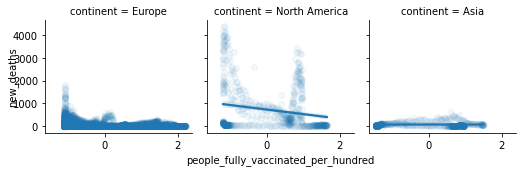

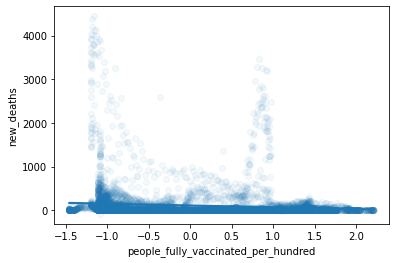

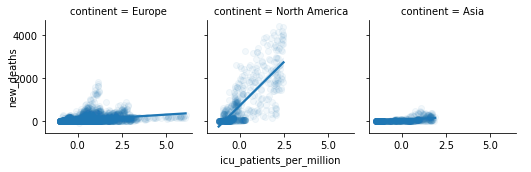

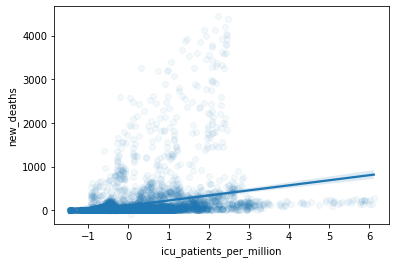

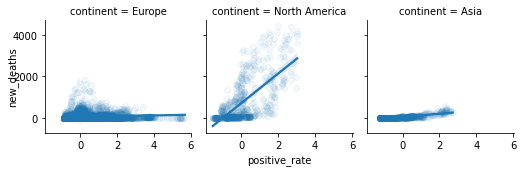

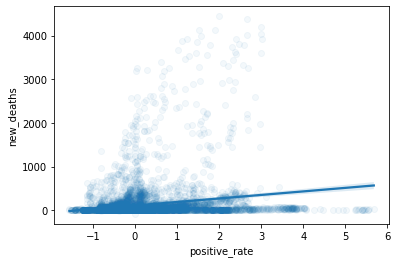

In [18]:
for feature_name in FEATURES_NAMES:
    # group-wise scatter plot
    plot_group_feature_split(merged, 
                             x_name=feature_name, 
                             y_name=TARGET_NAMES[0], 
                             group_name=GROUP_BY,
                             plot_type=sns.regplot)
    
    # group-wise scatter, same figure
    # plotFeature(plot_df, x_name=feature_name, y_name=TARGET_NAMES[0], group_name='location')

    # single scatter plot
    plt.figure()
    sns.regplot(data=merged, x=feature_name, y=TARGET_NAMES[0], scatter_kws={'alpha': 0.05})

### Perform regression

In [19]:
MIN_DATA_POINTS = 100

result = {}

print(f"Performing regression on\n{normalised_features.shape}, {normalised_features.columns.values}\n" +
      f"by {target.shape}, {target.columns.values}")

for (key, feature_grp), (_, target_grp) in zip(normalised_features.groupby(GROUP_BY), target.groupby(GROUP_BY)):
    X = feature_grp.drop(MERGE_NAMES, axis=1).reset_index(drop=True)
    Y = target_grp.drop(MERGE_NAMES, axis=1).reset_index(drop=True)

    if X.shape[0] > MIN_DATA_POINTS:
        test_features, test_targets, beta, cost = runRegression(X, Y, is_normalised=True)
        result[key] = {
            'test_features': test_features,
            'test_targets': test_targets,
            'beta': np.squeeze(beta),
            'cost': cost
        }
    else:
        print(f"{key:10.10}: too little data points {X.shape[0]}/{MIN_DATA_POINTS}")

X = normalised_features.drop(MERGE_NAMES, axis=1).reset_index(drop=True)
Y = target.drop(MERGE_NAMES, axis=1).reset_index(drop=True)
test_features, test_targets, beta, cost = runRegression(X, Y, is_normalised=True)
result['Overall'] = {
    'test_features': test_features,
    'test_targets': test_targets,
    'beta': np.squeeze(beta),
    'cost': cost
}

Performing regression on
(7832, 6), ['continent' 'location' 'date' 'people_fully_vaccinated_per_hundred'
 'icu_patients_per_million' 'positive_rate']
by (7832, 4), ['continent' 'location' 'date' 'new_deaths']


,group,r2,mse,adjusted_r2
0,Asia,0.788601,1596.564955,0.788520
1,Europe,0.207585,11408.763915,0.207282
2,North America,0.568135,541254.407600,0.567969
3,Overall,0.101070,124388.143465,0.100725


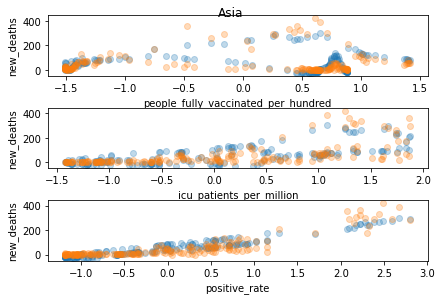

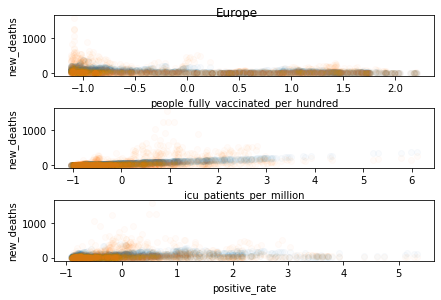

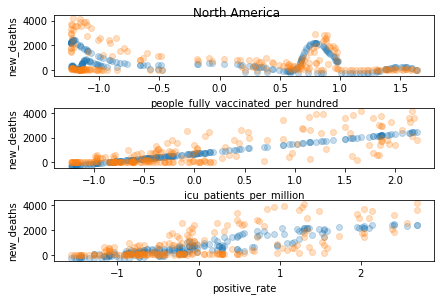

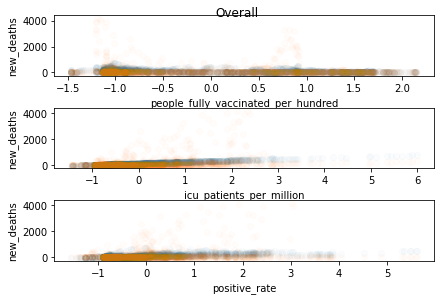

In [20]:
metrics = pd.DataFrame(columns=['group', 'r2', 'mse', 'adjusted_r2'])
n_features = len(FEATURES_NAMES)
n_datapoints = features.shape[0]

for group, res in result.items():
    df_features_test = res['test_features']
    df_target_test = res['test_targets'].squeeze()
    weights = res['beta']

    pred = predict(df_features_test, weights)
    
    feature_names = df_features_test.columns
    fig, ax = plt.subplots(len(feature_names), 1)
    fig.tight_layout()
    fig.suptitle(group)
    alph = 50 / df_features_test.shape[0]

    for i, feature_name in enumerate(feature_names):
        ax[i].scatter(df_features_test[feature_name], pred, alpha=alph)
        ax[i].scatter(df_features_test[feature_name], df_target_test, alpha=alph)
        ax[i].set(xlabel=feature_name, ylabel=TARGET_NAMES[0])

    # get evaluation metrics
    row = {}
    row['group'] = group
    row['mse'] = mean_squared_error(df_target_test, pred)
    row['r2'] = r2_score(df_target_test, pred)
    row['adjusted_r2'] = adjusted_r2(df_target_test, pred, n_features, n_datapoints)
    metrics = metrics.append(row, ignore_index=True)    

display(metrics)

## UNDP Dataset

In [ ]:
# RAW_DATA_FILE = '/content/drive/My Drive/2DTerm3/Raw Data/owid-covid-data.csv'
RAW_DATA_FILE = 'owid-covid-data.csv'
MERGE_NAMES = ['continent', 'location', 'date']
FEATURES_NAMES = ['people_fully_vaccinated_per_hundred', 'icu_patients_per_million', 'positive_rate']
TARGET_NAMES = ['new_deaths']
GROUP_BY = 'continent'

data = pd.read_csv(RAW_DATA_FILE)
col_names = data.columns
df_features = data.loc[:, MERGE_NAMES + FEATURES_NAMES]
df_target = data.loc[:, MERGE_NAMES + TARGET_NAMES]
# print(col_names)

## Exporting notebook

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!jupyter nbconvert --to PDF "/content/drive/My Drive/2DTerm3/DTPIII_Report.ipynb"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
[NbConvertApp] Converting notebook /content/drive/My Drive/2DTerm3/DTPIII_Report.ipynb to PDF
[NbConvertApp] Support files will be in DTPIII_Report_files/
[NbConvertApp] Making directory ./DTPIII_Report_files
[NbConvertApp] Making directory ./DTPIII_Report_files
[NbConvertApp] Making directory ./DTPIII_Report_files
[NbConvertApp] Writing 73746 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems

# Cleanup

In [ ]:
# unmount drive
# drive.flush_and_unmount()